In [40]:
import librosa
import numpy as np
import IPython.display as ipd
import scipy.io.wavfile as wavfile
import matplotlib.pyplot as plot
import soundfile as sf
from tensorflow import keras
import tensorflow as tf

In [41]:
class AudioStuff:
    
    def __init__(self, filename):
        self.filename = filename
        
    def audio_to_spectrogram(self):
        audio, sr = librosa.load(self.filename)
        D = np.abs(librosa.stft(audio))**2
        audio= librosa.feature.melspectrogram(y=audio, sr=sr, S=D)
        return (audio, sr)

In [42]:
def MergeSpectrogram(spectrometer1, spectrometer2):
        return (spectrogram1 + self.spectrogram2)/2

In [43]:
def gram_matrix(tensor):
    #https://www.datacamp.com/community/tutorials/implementing-neural-style-transfer-using-tensorflow
    """
    Computes the gram matrix of the input tensor, assuming it has exactly one layer.
    :param input_tensor: input tensor
    :return: gram matrix of the input tensor
    """
    temp = tensor
    temp = tf.squeeze(temp)
    fun = tf.reshape(temp, [temp.shape[2], temp.shape[0]*temp.shape[1]])
    result = tf.matmul(temp, temp, transpose_b=True)
    gram = tf.expand_dims(result, axis=0)
    return gram

In [44]:
def loss_c_func(mel_targets, mel_outputs):
        return tf.losses.mean_squared_error(mel_targets, mel_outputs)
        
def loss_s_func(mel_targets, mel_outputs):
        return tf.losses.mean_squared_error(gram_matrix(mel_targets), gram_matrix(mel_outputs))

In [45]:
def spectrogram_to_audio(spectrogram):
    res = librosa.feature.inverse.mel_to_audio(spectrogram)
    return res

In [46]:
# define the model
# construction

# I dont know if dense layers will be required have to look at the paper to see the model
def model_audio_tranfer(content_spectrogram, style_spectrogram, combination_spectrogram):
    # note according to keras lib sequential model is not beneficial here and vgg19 
    # is for images and cannot be used for audio 
    # for better result add dense layers have 3 functions and name them blocks and then these block 
    # would have softmax and dense layers
    # Flatten would be needed
    # N_FILTERS = 4096
    N_FILTERS = 256
    x_1 = content_spectrogram
    x_2 = style_spectrogram
    x_3 = combination_spectrogram
    _ , c_color_band, c_frequency, c_channel = tuple(content_spectrogram.shape)
    _ , s_color_band, s_frequency, s_channel = tuple(style_spectrogram.shape)
    _ , co_color_band, co_frequency, co_channel = tuple(combination_spectrogram.shape)
    
    
    y_1 = tf.keras.layers.Conv2D(N_FILTERS, (3, 3), activation="relu", 
                               strides = (2, 2), input_shape=(c_color_band, c_frequency, c_channel))(x_1)
    y_2 = tf.keras.layers.Conv2D(N_FILTERS, (3, 3), activation = "relu", strides = (2, 2), 
                                 input_shape=(s_color_band, s_frequency, s_channel))(x_2)
    
    y_3 = tf.keras.layers.Conv2D(N_FILTERS, (3, 3), activation = "relu", strides = (2, 2), 
                                 input_shape=(co_color_band, co_frequency, co_channel))(x_3)
    
    return (y_1, y_2, y_3)
#     model = tf.keras.models.Sequential([
#     tf.keras.layers.Conv2D(N_FILTERS, (3,3), activation = "relu",
#                           input_shape = (:,:,1)),
#     tf.keras.layers.MaxPooling2D(2, 2),
#     tf.keras.layers.Conv2D(N_FILTERS, (3,3), activation = "relu", input_shape = (:,:,1))
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(128, activation = "relu"),
#     tf.keras.layers.Dense(10, activation = "softmax"),
#])

#     model = tf.keras.models.Sequential()
#     model.add(tf.keras.layers.Conv2D(N_FILTERS, (3, 3), activation='relu')) # layer for content
#     model.add(tf.keras.layers.Conv2D(N_FILTERS, (3, 3), activation='relu')) # layer for style
#     print(model.layers[1].name)

In [47]:
def compute_loss(content_spectrogram, style_spectrogram, combination_spectrogram):
    style_weight = 1e-6
    content_weight = 2.5e-8
    # Initialize the loss
    loss = tf.zeros(shape=())
    
    #intialize the layers and there outputs
    content_features, style_features, combination_features= \
    model_audio_tranfer(content_spectrogram, style_spectrogram, combination_spectrogram)
    
    # Add content loss

    loss = loss + content_weight * loss_c_func(content_features, combination_features)
    # Add style loss

    sl = loss_s_func(style_features, combination_features)
    loss += (style_weight / len(style_features)) * sl

    # Add total variation loss
    #loss += total_variation_weight * total_variation_loss(combination_image)
    return loss

In [48]:
def compute_loss_and_grads(content_spectrogram, style_spectrogram, combination_spectrogram):
    with tf.GradientTape() as tape:
        loss = compute_loss(content_spectrogram, style_spectrogram, combination_spectrogram)
    grads = tape.gradient(loss, combination_spectrogram)
    return loss, grads

In [49]:
optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

content_object = AudioStuff("vocals.wav")
style_object = AudioStuff("accompaniment.wav")
content_spectrogram, content_rate = content_object.audio_to_spectrogram()
style_spectrogram, style_rate = style_object.audio_to_spectrogram()




s_color_band, s_frequency = style_spectrogram.shape
c_color_band, c_frequency = content_spectrogram.shape


# change 1 to the number of trainable batches ie the first dimension
content_spectrogram = tf.reshape(content_spectrogram, [1, c_color_band , c_frequency, 1])
style_spectrogram = tf.reshape(style_spectrogram, [1, s_color_band, s_frequency, 1])
combination_spectrogram  =   tf.Variable(content_spectrogram)


iterations = 100
for i in range(1, iterations + 1):
    #print(content_spectrogram)
    loss, grads = compute_loss_and_grads(
        content_spectrogram, style_spectrogram, combination_spectrogram
    )
    # works till here but comp will fail after this lol resource exhausted error (fix: change the hyperparameters)
    # 03:30AM 3rd Jan
    optimizer.apply_gradients([(grads, combination_spectrogram)])
    
# might have to do tf.sqeeze and then tf.reshape because the dimension is different
       

(128, 1293)


/Users/thuhin/opt/anaconda3/envs/spleeter/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Only one segment is calculated since parameter NFFT (=256) >= signal length (=128).
  


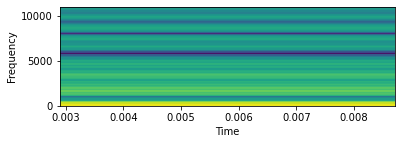

In [53]:
combination_spectrogram = tf.squeeze(combination_spectrogram)
print(combination_spectrogram.shape)
#colourband, frequency= combination_spectrogram.shape
#combination_spectrogram = tf.reshape(combination_spectrogram, [colourband, frequency
plot.subplot(212)
plot.specgram(combination_spectrogram,Fs=style_rate)
plot.xlabel('Time')
plot.ylabel('Frequency')
plot.show()

In [54]:
#wavfile.write("OUTPUT/outp4.wav", style_rate, merge_audio)
merge_audio = spectrogram_to_audio(combination_spectrogram.numpy())
sf.write("output.wav", merge_audio, samplerate=style_rate)

In [ ]:
# dont run this

if __name__ == '__main__':
    content_object = AudioStuff("vocals.wav")
    style_object = AudioStuff("accompaniment.wav")
    content_spectrogram, content_rate = content_object.audio_to_spectrogram()
    style_spectrogram, style_rate = style_object.audio_to_spectrogram()
    #print(content_spectrogram.shape)
    #print(style_spectrogram)
    object1 = SpectrogramStuff(content_spectrogram, style_spectrogram)
    print(object1.MergeSpectrogram().shape)
    #content_audio = spectrogram_to_audio(content_spectrogram)
    merge_spectrogram = object1.MergeSpectrogram()
    merge_audio = spectrogram_to_audio(merge_spectrogram)
    #style_audio = spectrogram_to_audio(style_spectrogram)
    wavfile.write("OUTPUT/outp3.wav", style_rate, merge_audio)

    
    